#https://go.criteo.net/TP3ENSAE
Solutions: https://colab.research.google.com/drive/1mFY63abCJazCsJwwPxoL_aqI0St0Tavw?usp=sharing

#Goal
- Understand Finetuning and try to match texts and images using CLIP

# Finetuning and CLIP

On many tasks, it is now common to initialize the network's weights using a similar architecture trained on some other data by modifying only the last layers. An example of how to do this is https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

The net used as a starting point is often designated as the "backbone", and the output of the backbone is named 'embedding'—the part doing the prediction the projection head.
 
Last year a model named CLIP got a lot of attention. It is trained using very simple cosine matching, trying to reduce the distance between some embeddings of images and the embedding of their legend. A pre-trained version is available at https://github.com/openai/CLIP

This sparkled a lot of derivative works, one of them beeing stable diffusion. 


Yet not necessary to answer the questions you may be interested in a [video explanation](https://www.youtube.com/watch?v=T9XSU0pKX2E) made by a researcher independent of the authors. 



**Q6.** CLIP claims to perform 0 shot classification by comparing the likelihood of several embedding of tuple (image, description). Adapt the Zero-shot example of the repository to perform 0-shot predictions on the Hymenoptera dataset. Do the same on Cifar-100.


**Q7.** Adapt the finetuning code of Q5 such that the network model from CLIP can now be used as the backbone for a fine tuning on Cifar-100 and 

**Q8.** Perform a training trying to tune the learning rate with a SGD optimizer and freezing/unfreezing the CLIP network. Also try different learning rate for SGD on the frozen paramters and the added layers. Can you find some recommendations? 

**Q9.** On the Cifar-100 dataset create embedding of images and  corresponding texts using 0-shot prediction (which is precisely the setting given in the example). Plot a few of the images and their corresponding texts using 2d PCA made on their common embedding space with a color depending if the point is from an image or from a text. Do you have any comment? Are the text and image spaces organized similarly? 

**Q10.** Does the training of Q7 improves the situation detected at Q9?

**Q11.** Try to improve the performances of Cifar-100 following recommendations of http://karpathy.github.io/2019/04/25/recipe/ and/or adding a multi-head attention layer instead of a single fully connected layer on the top of CLIP. 

In [ ]:
!nvidia-smi

Sun Feb  5 11:09:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install CLIP and download datasets

In [ ]:
# install CLIP
!conda install --yes -c pytorch pytorch=1.7.1 torchvision cudatoolkit=11.2
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 748.6 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fb9upwp5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fb9upwp5
  Resolved https://github.com/openai/CLIP.git to commit 3702849800aa56e2223035bccd1c6ef91c704ca8
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=26bbf0ceb047b21e14598636e19cc9ad78a4efa8fe39384d240cb960d7c2869f
  Stored in directory: /tmp/pip-ephem-wheel-cache-8q79fqxt/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip


In [ ]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100, ImageFolder
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download CIFAR dataset
cifar100 = CIFAR100(root='./data', download=True, train=False, transform=preprocess)

# download Hymenoptera dataset at https://download.pytorch.org/tutorial/hymenoptera_data.zip
!wget -P './data' https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q './data/hymenoptera_data.zip' -d './data'

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 246MiB/s]


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
--2023-02-05 11:10:09--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.33.88.63, 13.33.88.36, 13.33.88.85, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.33.88.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘./data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   107MB/s    in 0.4s    

2023-02-05 11:10:10 (107 MB/s) - ‘./data/hymenoptera_data.zip’ saved [47286322/47286322]



## Q6: zero-shot predictions

### Cifar100

In the first time, we perform zero-shot classification on a single sample, showing the top 5 predictions made by the model

In [ ]:
input_index = 1096
text_all_class = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

with torch.no_grad():
  text_features = model.encode_text(text_all_class)
  text_features /= text_features.norm(dim=-1, keepdim=True)

  image, class_id = cifar100[input_index]
  image_input = image.unsqueeze(0).to(device)
  image_features = model.encode_image(image_input)
  image_features /= image_features.norm(dim=-1, keepdim=True)

similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

print(f"The true label is {cifar100.classes[class_id]}")

print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

The true label is motorcycle

Top predictions:

      motorcycle: 92.47%
      lawn_mower: 4.04%
         bicycle: 0.62%
           plain: 0.50%
           woman: 0.19%


We can notice that the legend prediction corresponds well to the input image (the correct answer gets more than 90% probability).

Now, we compute the average prediction accuracy on the whole Cifar100 dataset.

In [ ]:
def evaluate(model, dataloader, text_all_class):
    n_correct = 0
    total = 0
    with torch.no_grad():
        text_features = model.encode_text(text_all_class)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        for images, labels in dataloader:
          images = images.to(device)
          image_features = model.encode_image(images)
          image_features /= image_features.norm(dim=-1, keepdim=True)

          similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
          _, indices = similarity.topk(1)
          indices = indices.reshape(-1,)
          n_correct += indices.eq(labels.to(device)).sum().item()
          total += labels.size(0)
    accuracy = n_correct / total
    return accuracy

In [ ]:
dataloader = torch.utils.data.DataLoader(cifar100, batch_size=64,
                                        shuffle=True, num_workers=2)
text_all_class = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
accuracy = evaluate(model, dataloader, text_all_class)
print(f"For CIFAR100, The accuracy of zero-shot inference is {accuracy*100:.2f}%")

For CIFAR100, The accuracy of zero-shot inference is 61.68%


Using ViT/B-32, we get an accuracy about **62%** by top1 similarity. If we refer to the [original paper of CLIP](https://cdn.openai.com/papers/Learning_Transferable_Visual_Models_From_Natural_Language.pdf), the accuracy of zero shot prediction on Cifar100 is **65.1%**.

Here are some [discussions](https://github.com/openai/CLIP/issues/153). It seems that we have to ensemble the prompts to achieve such accuracy in paper, instead of using one single template of prompt.

It proves that the quality of prompts could be a main factor of model performance.

### Hymenoptera dataset

In [ ]:
# refer to tutorial at https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_dir = './data/hymenoptera_data'
image_datasets = ImageFolder(os.path.join(data_dir, 'train'),
                                          preprocess)
text_all_class_hyme = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ['ant', 'bee'] ]).to(device)

In [ ]:
input_index = 24

with torch.no_grad():
  text_features = model.encode_text(text_all_class_hyme)
  text_features /= text_features.norm(dim=-1, keepdim=True)

  image_input_, class_id = image_datasets[input_index]
  image_input = (image_input_).unsqueeze(0).to(device)
  image_features = model.encode_image(image_input)
  image_features /= image_features.norm(dim=-1, keepdim=True)

similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(2)

print(f"The true label is {['ant', 'bee'][class_id]}")

print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{['ant', 'bee'][index]:>16s}: {100 * value.item():.2f}%")

The true label is ant

Top predictions:

             ant: 99.41%
             bee: 0.57%


On a randomly chosen sample, CLIP well predicts its class. 

In [ ]:
dataloader_hyme = torch.utils.data.DataLoader(image_datasets, batch_size=64,
                                        shuffle=True, num_workers=2)
text_all_class_hyme = torch.cat([clip.tokenize(f"a photo of a {c}") for c in ['ant', 'bee'] ]).to(device)
accuracy = evaluate(model, dataloader_hyme, text_all_class_hyme)
print(f"For Hymenoptera dataset, The accuracy of zero-shot inference is {accuracy*100:.2f}%")

For Hymenoptera dataset, The accuracy of zero-shot inference is 95.49%


## Q7: Fine tuning on CIFAR

Fine tuning on CLIP (based on Vision Transformer Base, with patch size 32)

In [ ]:
model_finetune, preprocess = clip.load('ViT-B/32', device, jit=False)

# Load the dataset
root = './data'
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)
trainloader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=64,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Adapt the fine tuning code from the [discussion](https://github.com/openai/CLIP/issues/83). CLIP uses mix-precision training: float32 for optimization and float16 for forward/backward, as discussed [here](https://github.com/openai/CLIP/issues/57). 

Thus, we need to convert parameters and grads to float32 before applying optimizer, then convert it back. See it in the following code.

In [ ]:
text_all_class = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_finetune.parameters(), lr=5e-5)
train_epoch = 3

model_finetune.train()
for epoch in range(train_epoch):  
    for inputs, labels in trainloader:
        texts = torch.cat([clip.tokenize(f"a photo of a {cifar100.classes[i]}") for i in np.array(labels)]).to(device)
        images = inputs.to(device) 

        optimizer.zero_grad()
        logits_per_image, logits_per_text  = model_finetune(images, texts)
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        total_loss.backward()

        if device == "cpu":
          optimizer.step()
        else:
          # convert the weights and to float32 
          model_finetune.float()
          optimizer.step()
          # convert back to float16
          clip.model.convert_weights(model_finetune)

    train_acc = evaluate(model_finetune, trainloader, text_all_class)    
    test_acc = evaluate(model_finetune, testloader, text_all_class)
    print(f"Epoch {epoch+1}: training accuracy is {train_acc*100:.3f}% || test accuracy is {test_acc*100:.3f}%")

Epoch 1: training accuracy is 75.094% || test accuracy is 68.820%
Epoch 2: training accuracy is 81.476% || test accuracy is 71.420%
Epoch 3: training accuracy is 85.228% || test accuracy is 73.630%


In [ ]:
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"There are {n_params:,} parameters in CLIP ViT-B/32 model.")
print(f"There are {len(train)} training samples.")

There are 151,277,313 parameters in CLIP ViT-B/32 model.
There are 50000 training samples.


There are more than 150 millions trainable parameters. That's why the fine-tune is really slow (more than 10 minutes for 3 epochs of 50,000 traning samples). 

In [ ]:
# save the model 

torch.save({
        'epoch': train_epoch,
        'model_state_dict': model_finetune.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, "./CLIP_ckpt.pt")

In [ ]:
# reload the fine-tuned model

# model, preprocess = clip.load("ViT-B/32",device=device,jit=False)
# checkpoint = torch.load("./CLIP_ckpt.pt")
# model.load_state_dict(checkpoint['model_state_dict'])

## Q8: Tune the learning rate

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# model_sgd, preprocess = clip.load('ViT-B/32', device, jit=False)

# Download CIFAR dataset
cifar100 = CIFAR100(root='./data', download=True, train=False, transform=preprocess)

# Load the dataset
root = './data'
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)
trainloader = torch.utils.data.DataLoader(train, batch_size=64,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=64,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
text_all_class = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

def tune_lr_sgd(trainloader, testloader, text_all_class, lr, train_epoch = 5):
  model_sgd, _ = clip.load('ViT-B/32', device, jit=False)
  loss_img = torch.nn.CrossEntropyLoss()
  loss_txt = torch.nn.CrossEntropyLoss()

  optimizer = torch.optim.SGD(model_sgd.parameters(), lr)

  model_sgd.train()
  train_accs = np.zeros(train_epoch)
  test_accs = np.zeros(train_epoch)
  for epoch in range(train_epoch):  
      for inputs, labels in trainloader:
          texts = torch.cat([clip.tokenize(f"a photo of a {cifar100.classes[i]}") for i in np.array(labels)]).to(device)
          images = inputs.to(device) 

          optimizer.zero_grad()
          logits_per_image, logits_per_text  = model_sgd(images, texts)
          ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
          total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
          total_loss.backward()

          if device == "cpu":
            optimizer.step()
          else:
            # convert the weights and to float32 
            model_sgd.float()
            optimizer.step()
            # convert back to float16
            clip.model.convert_weights(model_sgd)

      train_accs[epoch] = evaluate(model_sgd, trainloader, text_all_class)    
      test_accs[epoch] = evaluate(model_sgd, testloader, text_all_class)
      # print(f"Epoch {epoch+1}: training accuracy is {train_acc*100:.3f}% || test accuracy is {test_acc*100:.3f}%") 
  return train_accs, test_accs

In [ ]:
lrs = [1e-2, 1e-3, 1e-5]
accs = {}
for i, lr in enumerate(lrs):
  accs[i] = tune_lr_sgd(trainloader, testloader, text_all_class, lr, 3)

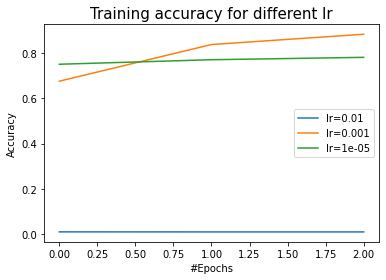

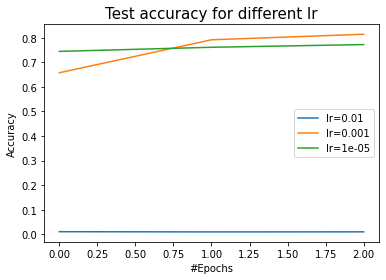

In [ ]:
x = np.arange(3)
for i in range(3):
  plt.plot(x, accs[i][0], label=f"lr={lrs[i]}")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Accuracy")
plt.title("Training accuracy for different SGD lr", fontsize=15)
plt.show()

for i in range(3):
  plt.plot(x, accs[i][1], label=f"lr={lrs[i]}")
plt.legend()
plt.xlabel("#Epochs")
plt.ylabel("Accuracy")
plt.title("Test accuracy for different SGD lr", fontsize=15)
plt.show()

**Observation**: when the learning rate is too large, like in the case lr=0.01, the performance of the CLIP is very poor and does not improve through training epochs. What's more, the accuracy where lr=1e-3 is higher than the accuracy where lr=1e-5 after 3 training epochs, so the performance does not necessarily improve when we take smaller learning rates.

**Recommendation**: When we fine-tune the big models (like CLIP), the learning rate should not be too big. That would lose the important information contained in the model and degrade the performance. Choose an appropriate learning rate is important. But it seems like a problem-specific task which has no universal principals.

## Q8: Freezing CLIP and add layers

Here, we'd like to add some fully connected layers on top of CLIP. 

One common way to do that is to remove the last layer in the first time (or just set them as `Identity()`); then add some fully connected layers as "classifier head". However, in CLIP, it is not so easy. 

In `forward` function of CLIP's source code, the blocks are not sequentially used: `self.visual` and `self.transformer` are called in parallel, respectively in `encode_image` and `encode_text`. Thus, adding sequentially the fully connected layers would not work here. 

Inspired by source code, we apply fully connected layers on images features and text features. Then we compute their similarities, just as in source code.

In [ ]:
class MyCLIP(torch.nn.Module):
    def __init__(self, model_CLIP):
        super().__init__()
        self.model = model_CLIP
        self.fc1 = torch.nn.Linear(512, 512, dtype=torch.float16)
        self.fc2 = torch.nn.Linear(512, 512, dtype=torch.float16)

    def forward(self, imgs, text):
        # x1, x2 = self.model(imgs, text)
        # x1 = self.fc1(x1)
        # x1 = self.fc2(x1)
        # x2 = x1.t()
        image_features = self.model.encode_image(imgs)
        image_features = self.fc1(image_features)
        image_features = image_features / image_features.norm(dim=1, keepdim=True)

        text_features = self.model.encode_text(text)
        text_features = self.fc2(text_features)
        text_features = text_features / text_features.norm(dim=1, keepdim=True)

        logit_scale = self.model.logit_scale.exp()
        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logits_per_image.t()
        return logits_per_image, logits_per_text
    
    def evaluate(self, dataloader, text_all_class):
        n_correct = 0
        total = 0
        with torch.no_grad():
            text_features = self.model.encode_text(text_all_class)
            text_features = self.fc2(text_features)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            for images, labels in dataloader:
              images = images.to(device)
              image_features = self.model.encode_image(images)
              image_features = self.fc1(image_features)
              image_features /= image_features.norm(dim=-1, keepdim=True)

              similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
              _, indices = similarity.topk(1)
              indices = indices.reshape(-1,)
              n_correct += indices.eq(labels.to(device)).sum().item()
              total += labels.size(0)
        accuracy = n_correct / total
        return accuracy

In [ ]:
model, preprocess = clip.load('ViT-B/32', device, jit=False)
myModel = MyCLIP(model)
myModel = myModel.to(device)

# Load the dataset
batch_size = 64
root = './data'
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# we freeze the CLIP network
for para in myModel.model.parameters():
    para.requires_grad = False

In [ ]:
train_epoch = 5
optimizer = torch.optim.SGD(myModel.parameters(), lr=1e-3)
loss_img = torch.nn.CrossEntropyLoss()
loss_txt = torch.nn.CrossEntropyLoss()
text_all_class = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
for epoch in range(train_epoch):  
    for inputs, labels in trainloader:
        texts = torch.cat([clip.tokenize(f"a photo of a {cifar100.classes[i]}") for i in np.array(labels)]).to(device)
        images = inputs.to(device) 

        optimizer.zero_grad()
        logits_per_image, logits_per_text  = myModel(images, texts)
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        total_loss.backward()
        optimizer.step()

    train_acc = myModel.evaluate(trainloader, text_all_class)    
    test_acc = myModel.evaluate(testloader, text_all_class)
    print(f"Epoch {epoch+1}: training accuracy is {train_acc*100:.3f}% || test accuracy is {test_acc*100:.3f}%")

Epoch 1: training accuracy is 59.216% || test accuracy is 58.650%
Epoch 2: training accuracy is 67.576% || test accuracy is 66.660%
Epoch 3: training accuracy is 71.200% || test accuracy is 69.700%
Epoch 4: training accuracy is 72.948% || test accuracy is 71.180%
Epoch 5: training accuracy is 74.254% || test accuracy is 72.440%


Using SGD optimizer with learning rate 1e-3 and by training only the last linear layer added on top of CLIP, we obtained a similar accuracy after 5 epochs compared with the results obtained by fine tuning the CLIP on CIFAR. 

We would recommend adding some layers as classifier head to the CLIP network, freezing the CLIP and training only the added layers instead of the big network CLIP, since it would be much more faster.

## Q9: 2d PCA on common embedding space for images and texts

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
def plot_2d_embeddings(model, dataset):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,
                                            shuffle=True, num_workers=2)
    ## Take a few samples (one batch)
    one_batch = next(iter(dataloader))
    imgs, labels = one_batch
    texts = torch.cat([clip.tokenize(f"a photo of a {dataset.classes[i]}") for i in np.array(labels)]).to(device)
    imgs, labels = imgs.to(device), labels.to(device)

    image_features = model.encode_image(imgs)
    text_features = model.encode_text(texts)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # fit the PCA model
    pca = PCA(n_components=2)
    pca.fit(torch.cat([image_features, text_features]).cpu().detach().numpy())
    # Transform 
    image_features_2d = pca.transform(image_features.cpu().detach().numpy())
    text_features_2d = pca.transform(text_features.cpu().detach().numpy())

    plt.scatter(image_features_2d[:,0], image_features_2d[:,1], color='blue')
    plt.scatter(text_features_2d[:,0], text_features_2d[:,1], color='red')
    plt.show()


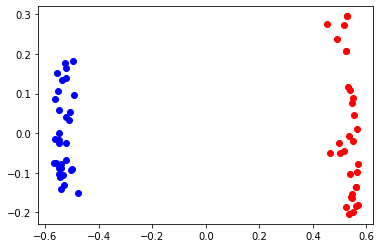

In [ ]:
plot_2d_embeddings(model, cifar100)

The red points are text embeddings, the blue ones are image embeddings. 

In their common space, the text and imgages embeddings are "symmetrically" organised. Moreover, the text and image spaces are organized similarly: they have respectively the similar coordinate in x-axis.

## Q10: Explore the improvements brought by fine tuning

To check the possible improvements brought by fine tuning, it is sufficient to replace the original model by the fine-tuned one.

In [ ]:
##### If there is fine-tuned model, no need to execute it #####

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
##### If there is fine-tuned model, no need to execute it #####

# Get the checkpoint mounted at Google Drive
checkpoint = torch.load("CLIP_ckpt.pt")

# Reload the model
model_finetune, preprocess = clip.load("ViT-B/32", device=device, jit=False)
model_finetune.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

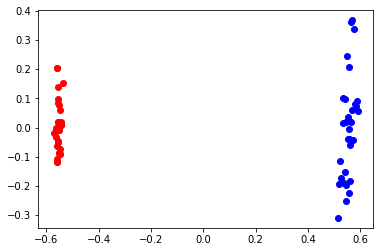

In [ ]:
plot_2d_embeddings(model_finetune, cifar100)

For text and images embeddings respectively, the restrictions on first coordinate (on x-axis) are more strict. That is to say, their respective x-axis are more similar. 

Other observation is that the text and image embeddings (the red points and blue ones) "exchange" their position after fine-tuning.

#Additional  considerations and other great tools

##Fast KNN
It is common to build costly embeddings selecting one layer close to the end of a deep net as a representation. Then looking for similarities becomes a k nearest neighbors search. As the dimension is almost always >100, no exact implementation runs in sub-linear time.   Thus,  we often conduct an approximate one that uses hyperplanes to build hashes to scale. The library [FAISS](https://github.com/facebookresearch/faiss) proposes an efficient implementation of this strategy. 

##Features stores
Often a fast but inconvenient raw data source is used to store the data stream. Then some transformations are applied regularly to build the features used by the predictive algorithm. This comes with a problem: each new project needs new features making the transformation step more and more costly and possibly inconsistent over time. Feature store is a concept introduced in 2020 to answer this problem by versioning the feature extraction. Read more at https://eugeneyan.com/writing/feature-stores/

##Discovering some of the deep learning concepts
- Each article is a gem: https://distill.pub/

- The [course of François Fleuret](https://fleuret.org/dlc/) is free and offers an excellent tour. 


##Empirical lessons from training deep nets
In my experience, these are good practices when training deep nets: http://karpathy.github.io/2019/04/25/recipe/

Nevertheless, since early 2021, the remark on self-supervised should be mitigated with respect to the successes of CLIP/ALIGN/BYOL. 

##Large dataset
There exist specialized dataloaders to handle large data: 
- [Webdataset](https://github.com/webdataset/webdataset)
- [Amazon S3 format](https://aws.amazon.com/fr/blogs/machine-learning/announcing-the-amazon-s3-plugin-for-pytorch/)

Also, Tensorflow is more mature for serving while being more painful to use. Care about automatic translation from PyTorch using ONNX, which can strongly degrade the metrics of the network. Google researchers are currently often using [Jax](https://github.com/google/jax).

##Demo time
[Streamlit](https://streamlit.io/) and [Gradio](https://gradio.app/) are a super simple way to build an HTML interface to a python ML model. As a bonus, Gradio event uses the inputs to build automatically an API following the OpenAPI standards.  

## Some food to think
- As an average deep learner: https://marksaroufim.substack.com/p/working-class-deep-learner
- As a Ph.D. student: https://www.cs.cmu.edu/~harchol/gradschooltalk.pdf 


##More code examples

Many examples are available on the net, here it is one code generator for basic classification with some intrumentation and parallel training.
https://share.streamlit.io/pytorch-ignite/code-generator